In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier


In [3]:
# Load your dataset
df = pd.read_csv("creditcard.csv")  # Make sure the file is in the same folder
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [4]:
# Scale 'Amount' and 'Time'
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Drop original columns
df.drop(['Amount', 'Time'], axis=1, inplace=True)

# Rearranging columns
scaled_data = df[['scaled_time', 'scaled_amount'] + [col for col in df.columns if col not in ['scaled_time', 'scaled_amount', 'Class']] + ['Class']]


In [5]:
X = scaled_data.drop('Class', axis=1)
y = scaled_data['Class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())


Before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


In [6]:
# LightGBM
lgb_model = LGBMClassifier()
lgb_model.fit(X_train_smote, y_train_smote)
y_pred_lgb = lgb_model.predict(X_test)

# MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=100, random_state=42)
mlp_model.fit(X_train_smote, y_train_smote)
y_pred_mlp = mlp_model.predict(X_test)


[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


📊 LightGBM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.49      0.86      0.62        98

    accuracy                           1.00     56962
   macro avg       0.75      0.93      0.81     56962
weighted avg       1.00      1.00      1.00     56962



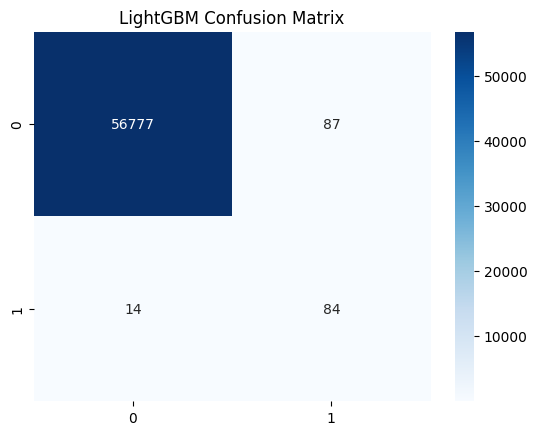

📊 MLP Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.68      0.83      0.75        98

    accuracy                           1.00     56962
   macro avg       0.84      0.91      0.87     56962
weighted avg       1.00      1.00      1.00     56962



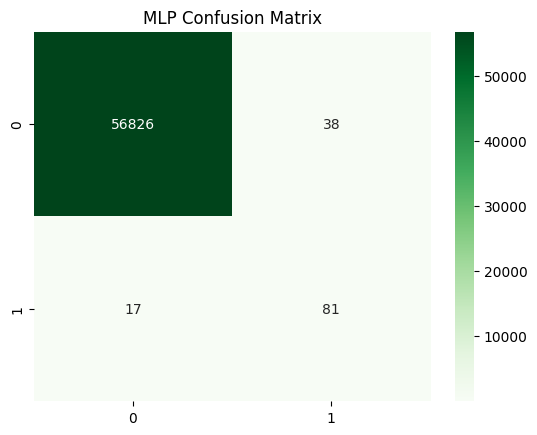

In [7]:
# LightGBM Evaluation
print("📊 LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))
sns.heatmap(confusion_matrix(y_test, y_pred_lgb), annot=True, fmt='d', cmap='Blues')
plt.title("LightGBM Confusion Matrix")
plt.show()

# MLP Evaluation
print("📊 MLP Classification Report:")
print(classification_report(y_test, y_pred_mlp))
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Greens')
plt.title("MLP Confusion Matrix")
plt.show()
